<a href="https://colab.research.google.com/github/stanislavfort/adversaries_to_OOD_detection/blob/main/adversaries_to_strong_OOD_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the key results from
# **Adversarial vulnerability of powerful near out-of-distribution detection** 
by Stanislav Fort

This is Colab performs a key experiments from **Adversarial vulnerability of powerful near out-of-distribution detection** by Stanisalv Fort. It uses a large, pretrained and finetuned [Vision Transformer](https://arxiv.org/abs/2010.11929), extracts its embeddings, and performs OOD detection on the hard near-OOD [CIFAR-100 vs CIFAR-10 task](https://paperswithcode.com/sota/out-of-distribution-detection-on-cifar-100-vs). It then calculates adversarial examples against the Mahalanobis distance and *Relative* Mahalanobis distance scores and shows how the AUROC drops with image perturbation norm. It also compares it to the baseline of using the Max of Softmax Probabilities OOD score.

This Colab is using parts of the Google [Colab on using their pretrained and finetuned transformers](https://github.com/google-research/vision_transformer). We modified the `models.py` and load it from our own [repository](https://github.com/stanislavfort/adversaries_to_OOD_detection) to allow for the extraction of image embeddings from the penultimate layer of the ViT that we use for OOD detection. 

You should expect to run this Colab from top to bottom in around 20 minutes on a single free Colab GPU. It is by default extracting embeddings only for 1/10 of the train and test sets of CIFAR-10 and CIFAR-100 to speed things up. If you want to change that, just set `N_test = 10000` and `N_train = 50000`.


The *Relative* Mahalanobis distance is more robust to adversarial perturbations then the standard Mahalanobis distance, which in turn is more robust than the Max of Softmax Probabilities (MSP).

You should expect to produce plots analogous to the following:

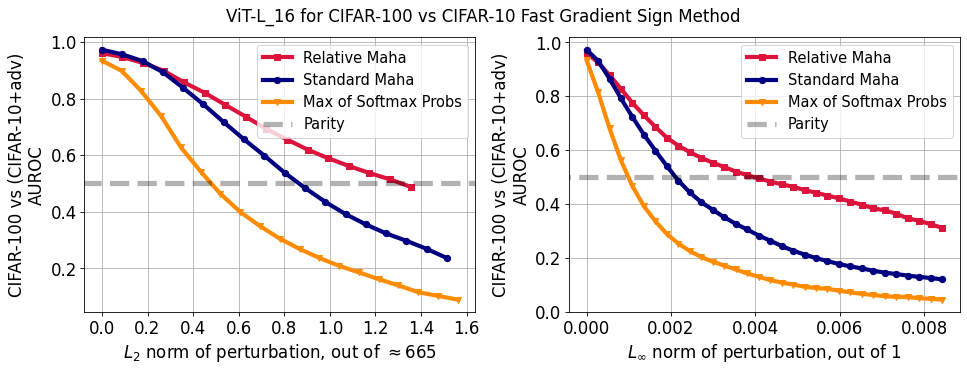

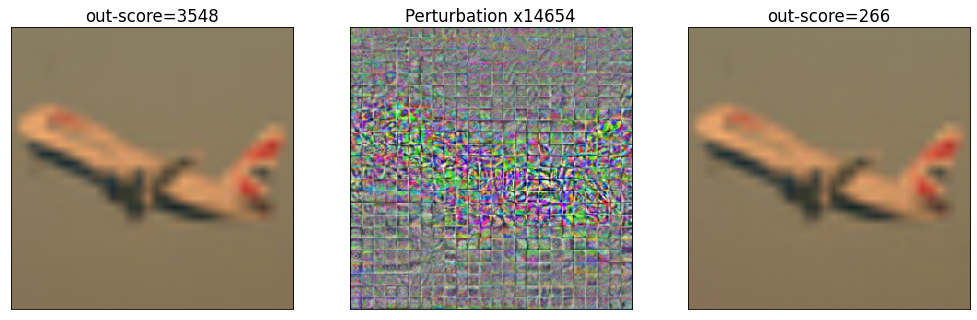

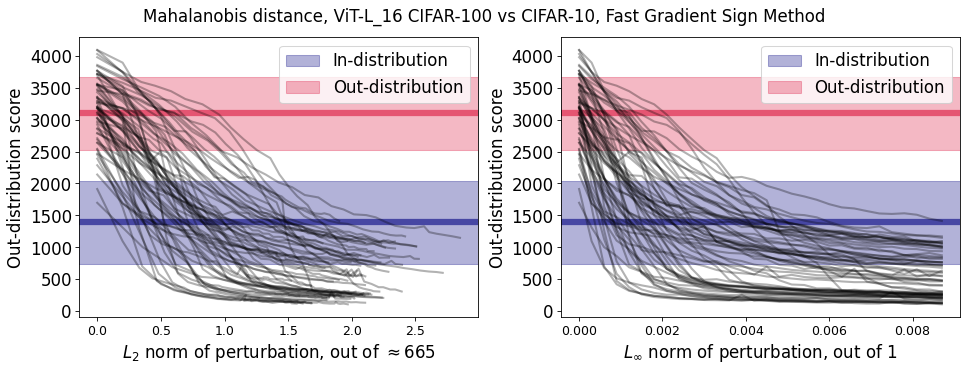

In [30]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform 
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [31]:
%env

{'SHELL': '/bin/bash',
 'NVIDIA_VISIBLE_DEVICES': 'all',
 'TMUX': '/tmp//tmux-0/default,1828,0',
 'HOSTNAME': '7f439c072393',
 'NVIDIA_REQUIRE_CUDA': 'cuda>=11.2 brand=tesla,driver>=418,driver<419',
 'PWD': '/opt/home3/swyoon',
 'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
 'NV_CUDA_CUDART_VERSION': '11.2.146-1',
 'HOME': '/root',
 'LANG': 'C.UTF-8',
 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.dz=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.zst=01;31:*.tzst=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.sar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7

# Imports and loading

In [32]:
import numpy as np

In [33]:
# ![ -d vision_transformer ] 
# !pwd

In [34]:
# # Fetch vision_transformer repository.
# ![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer

In [35]:
# # Install dependencies.
# !pip install -qr vision_transformer/vit_jax/requirements.txt

In [36]:
# !ls vision_transformer/vit_jax/

In [37]:
# # fetch out repository to get the modified models.py file with the pre-logits extraction
# !git clone --depth=1 https://github.com/stanislavfort/adversaries_to_OOD_detection

In [38]:
# !rm vision_transformer/vit_jax/models.py
# !cp adversaries_to_OOD_detection/models.py vision_transformer/vit_jax/

In [39]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

# %load_ext autoreload
# %autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [40]:
# #to add the prelogits versions
# from google.colab import files

# files.view('vision_transformer/vit_jax/models.py')

In [41]:
! pip freeze | grep jax

jax==0.3.16
jaxlib==0.3.15+cuda11.cudnn805


In [42]:
import tensorflow

In [43]:
!nvidia-smi

Sun Sep  4 17:59:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:18:00.0 Off |                  Off |
|  0%   25C    P8    26W / 300W |      8MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:5E:00.0 Off |                  Off |
|  0%   

In [44]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


# Loading ViT checkpoints from Google Brain repo

### Load a checkpoint

In [45]:
#selecting a ViT checkpoint
filename = 'L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

# print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

In [46]:
ds, ds_info = tfds.load(tfds_name, with_info=True,batch_size=128)
ds_info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    dis

In [47]:
model_config2 = {k: v for k, v in model_config.items() if k != 'model_name'}

In [48]:
# Get a clean model
model = models.VisionTransformer(
    num_classes=ds_info.features['label'].num_classes, **model_config2)

In [49]:
path = '/opt/home3/swyoon/exploring_the_limits_of_OOD_detection/L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384.npz'

In [50]:
# Load a checkpoint from cloud
# takes a while for a big model
params = checkpoint.load(path)

In [51]:
# out modified model that outputs pre-logits = embeddings for OOD detection
model_prelogits = models.VisionTransformer_prelogits(
    num_classes=ds_info.features['label'].num_classes, **model_config2)

# Getting unaugmented datasets

In [52]:
def pp(img, sz):
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

In [53]:
import tensorflow_datasets as tfds 
import tensorflow as tf

def prepare_pure_dataset(ds_in, num_classes,repeats = 1,shuffle=True, batch_size=128):

  ds_in = ds_in.map(lambda d: {"image": pp(d["image"],resolution), "label": d["label"]}, tf.data.experimental.AUTOTUNE)

  ds_in = ds_in.repeat(repeats)
  if shuffle:
    ds_in = ds_in.shuffle(200000)

  ds_in = ds_in.batch(batch_size, drop_remainder=False)

  return ds_in

In [54]:
batch_size = 128

cifar10_ds_train = prepare_pure_dataset(tfds.load('cifar10', split='train', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar10_ds_test = prepare_pure_dataset(tfds.load('cifar10', split='test', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar100_ds_train = prepare_pure_dataset(tfds.load('cifar100', split='train', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)
cifar100_ds_test = prepare_pure_dataset(tfds.load('cifar100', split='test', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)

In [55]:
#verification
def get_value_spreads_for_dataset(ds_in):
  batch = next(ds_in.as_numpy_iterator())
  images = batch["image"]
  min_now,mean_now,max_now = np.min(images),np.mean(images),np.max(images)
  return min_now,mean_now,max_now

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_test)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_test)
print(min_now,mean_now,max_now)


0.0 0.47670496 1.0
0.0 0.4786665 1.0
0.0 0.5022136 1.0
0.0 0.47278368 1.0


# Prelogits extraction

## Extractor

In [56]:
import time

def standalone_get_prelogits(params, ds_in,image_count=50000):
  """Returns prelogits on the dataset"""
  prelogits_all = []
  logits_all = []
  labels_all = []

  ts = []

  t1 = time.time()

  for batch in ds_in.as_numpy_iterator():

    prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)
    logits = model.apply({'params': params}, batch["image"], train=False)

    prelogits_all.append(prelogits)
    logits_all.append(logits)
    labels_all.append(batch["label"])

    count_so_far = len(np.concatenate(prelogits_all,axis=0))

    t2 = time.time()
    ts.append(t2-t1)
    t1 = time.time()

    t_rem = (image_count-count_so_far)*np.mean(ts)/batch_size

    print("Images done="+str(count_so_far)+" time remaining="+str(int(t_rem))+"s")

    if count_so_far >= image_count:
      break #early break for subsets of data

  return np.concatenate(prelogits_all,axis=0), np.concatenate(logits_all,axis=0), np.concatenate(labels_all,axis=0)

## Getting the prelogits

The full datasets extraction will take some time. Taking a 1/10 subset is sufficient to show the effectivness of the Mahalanobis distance and Relative Mahalanobis distance as compared to the Maximum over Softmax Probabilities and runs in 20 mins on a single V100 GPU in a Colab (probably slower on a P100).

In [57]:
# choosing the subsets of the train and test set to extract embeddings for
N_train = 50000
N_test = 10000

assert N_train <= 50000
assert N_test <= 10000

### CIFAR-10 test (1.5 minutes)

In [58]:
cifar10_test_prelogits, cifar10_test_logits, cifar10_test_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=3679s
Images done=256 time remaining=3197s
Images done=384 time remaining=3007s
Images done=512 time remaining=2899s
Images done=640 time remaining=2809s
Images done=768 time remaining=2744s
Images done=896 time remaining=2692s
Images done=1024 time remaining=2638s
Images done=1152 time remaining=2588s
Images done=1280 time remaining=2538s
Images done=1408 time remaining=2493s
Images done=1536 time remaining=2451s
Images done=1664 time remaining=2407s
Images done=1792 time remaining=2366s
Images done=1920 time remaining=2330s
Images done=2048 time remaining=2290s
Images done=2176 time remaining=2251s
Images done=2304 time remaining=2210s
Images done=2432 time remaining=2170s
Images done=2560 time remaining=2130s
Images done=2688 time remaining=2092s
Images done=2816 time remaining=2054s
Images done=2944 time remaining=2015s
Images done=3072 time remaining=1978s
Images done=3200 time remaining=1940s
Images done=3328 time remaining=1902s
Images done=3456 ti

In [59]:
! nvidia-smi

Sun Sep  4 18:47:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:18:00.0 Off |                  Off |
|  0%   32C    P2    98W / 300W |   1103MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:5E:00.0 Off |                  Off |
|  0%   

In [60]:
cifar10_test_prelogits.shape

(10000, 1024)

### CIFAR-100 test (1.5 minutes)

In [61]:
cifar100_test_prelogits, cifar100_test_logits, cifar100_test_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=2749s
Images done=256 time remaining=2743s
Images done=384 time remaining=2699s
Images done=512 time remaining=2667s
Images done=640 time remaining=2634s
Images done=768 time remaining=2602s
Images done=896 time remaining=2569s
Images done=1024 time remaining=2535s
Images done=1152 time remaining=2502s
Images done=1280 time remaining=2466s
Images done=1408 time remaining=2433s
Images done=1536 time remaining=2398s
Images done=1664 time remaining=2362s
Images done=1792 time remaining=2326s
Images done=1920 time remaining=2287s
Images done=2048 time remaining=2250s
Images done=2176 time remaining=2211s
Images done=2304 time remaining=2175s
Images done=2432 time remaining=2139s
Images done=2560 time remaining=2103s
Images done=2688 time remaining=2068s
Images done=2816 time remaining=2032s
Images done=2944 time remaining=1996s
Images done=3072 time remaining=1959s
Images done=3200 time remaining=1923s
Images done=3328 time remaining=1887s
Images done=3456 ti

### CIFAR-10 train (8 minutes)

In [ ]:
cifar10_train_prelogits, cifar10_train_logits, cifar10_train_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=14443s
Images done=256 time remaining=14124s
Images done=384 time remaining=14048s
Images done=512 time remaining=13917s
Images done=640 time remaining=13846s
Images done=768 time remaining=13815s
Images done=896 time remaining=13804s
Images done=1024 time remaining=13753s
Images done=1152 time remaining=13737s
Images done=1280 time remaining=13712s
Images done=1408 time remaining=13688s
Images done=1536 time remaining=13667s
Images done=1664 time remaining=13642s
Images done=1792 time remaining=13621s
Images done=1920 time remaining=13595s
Images done=2048 time remaining=13566s
Images done=2176 time remaining=13516s
Images done=2304 time remaining=13490s
Images done=2432 time remaining=13451s
Images done=2560 time remaining=13418s
Images done=2688 time remaining=13374s
Images done=2816 time remaining=13342s
Images done=2944 time remaining=13302s
Images done=3072 time remaining=13256s
Images done=3200 time remaining=13218s
Images done=3328 time remaining=

### CIFAR-100 train (8 minutes)

In [ ]:
cifar100_train_prelogits, cifar100_train_logits, cifar100_train_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_train, 
    image_count=N_train
    )

## Accuracies

In [ ]:
# checking the accuracy on CIFAR-100

finetune_test_acc = np.mean(
    np.argmax(cifar100_test_logits,axis=-1) == cifar100_test_labels
    )

print("CIFAR-100 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar100_train_logits,axis=-1) == cifar100_train_labels
    )

print("CIFAR-100 train accuracy = "+str(finetune_train_acc))

# Computing the near-OOD CIFAR-100 $\to$ CIFAR-10 AUROC

In [ ]:
cifar10_test_embeds = cifar10_test_prelogits
cifar10_y_test = cifar10_test_labels
cifar10_test_preds = cifar10_test_logits

cifar100_test_embeds = cifar100_test_prelogits
cifar100_y_test = cifar100_test_labels
cifar100_test_preds = cifar100_test_logits

cifar10_train_embeds = cifar10_train_prelogits
cifar10_y_train = cifar10_train_labels
cifar10_train_preds = cifar10_train_logits

cifar100_train_embeds = cifar100_train_prelogits
cifar100_y_train = cifar100_train_labels
cifar100_train_preds = cifar100_train_logits

## Computing Mahalanobis means and covariances

In [ ]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

In [ ]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict

In [ ]:
'''save intermediate results for later use'''

def get_intermediate(
    indist_train_embeds_in,
    indist_train_labels_in,
#     indist_test_embeds_in,
#     outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
#   indist_test_embeds_in_touse = indist_test_embeds_in
#   outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)
#     cov_inv_now = np.linalg.inv(cov_now + eps * np.eye(len(cov_now)))    

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

#   out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
#   in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

#   out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
#   in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

#   out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
#   in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

#   if subtract_train_distance:
#     out_scores = out_scores - out_totrain
#     in_scores = in_scores - in_totrain


#   onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
#   scores = np.concatenate([out_scores,in_scores],axis=0)

  return description, maha_intermediate_dict

In [ ]:
description, maha_intermediate_dict = get_intermediate(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
#         np.array(cifar100_test_embeds)[:,:],
#         np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


In [ ]:
description

In [ ]:
maha_intermediate_dict.keys()

In [ ]:
type(maha_intermediate_dict['mean'])

In [ ]:
type(maha_intermediate_dict)

In [77]:
cifar10_test_embeds.shape

(10000, 1024)

In [ ]:
import pickle

In [ ]:
pickle.dump(maha_intermediate_dict, open('maha_intermediate_dict_full.pkl', 'wb'))

---

In [83]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1] 
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0] 

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

## Standard Mahalanobis distance

In [78]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


In [79]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = cifar100_test_embeds

outdist_test_embeds = cifar10_test_embeds

indist_dists = []
for c in range(100):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

outdist_dists = []
for c in range(100):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)



In [80]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

# for making the plot for adversaries later
maha_outdist_scores = outdist_min
maha_indist_scores = indist_min

In [81]:
print("CIFAR-100 score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("CIFAR-10 score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

CIFAR-100 score = 1066.9103261274315+-477.59266209926324
CIFAR-10 score = 2379.3726603095038+-427.9758654856708


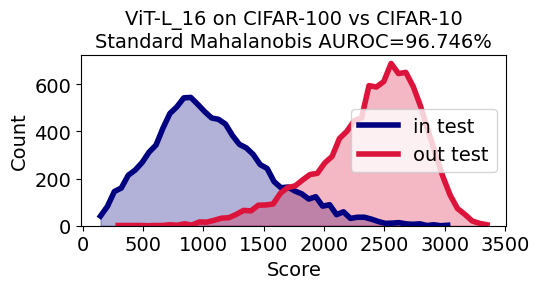

In [84]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

maha_auroc = auroc

## Relative Mahalanobis distance

In [46]:
train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [47]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = True,
    )



In [48]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [49]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

# for making the plot for adversaries later
ratio_outdist_scores = outdist_scores
ratio_indist_scores = indist_scores

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [50]:
print("CIFAR-100 score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("CIFAR-10 score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

CIFAR-100 score = 53.77694878377349+-140.80415215057536
CIFAR-10 score = 479.0441921371529+-131.62006205389773


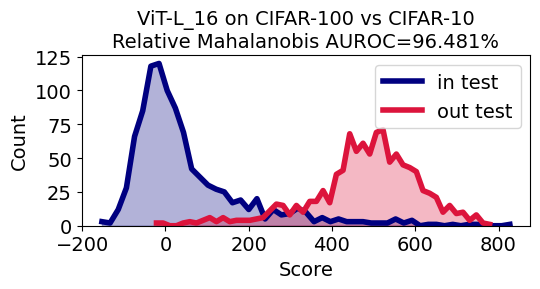

In [51]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nRelative Mahalanobis"
    )

ratio_auroc = auroc

## Max of Softmax Probabilities score

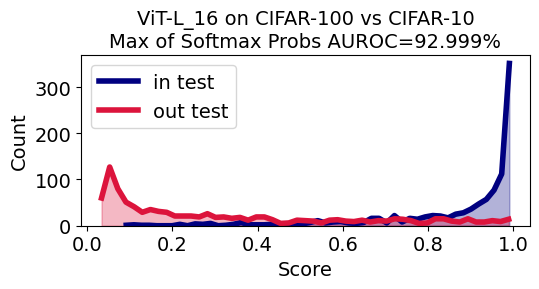

In [52]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(cifar100_test_logits),axis=-1),
     np.max(np_softmax(cifar10_test_logits),axis=-1),
    ],axis=0)
)

# for making the plot for adversaries later
MSP_outdist_scores = np.max(np_softmax(cifar10_test_logits),axis=-1)
MSP_indist_scores = np.max(np_softmax(cifar100_test_logits),axis=-1)

onehots = np.array(
    [1]*len(cifar100_test_logits)+[0]*len(cifar10_test_logits)
)

auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nMax of Softmax Probs",
    swap_classes=True,
    )

MSP_auroc = auroc

# Adversarial examples to OOD score

## Score and grad utils

In [53]:
import jax.numpy as jnp
import jax

from jax.config import config
config.update("jax_enable_x64", True)

In [54]:
def get_score(
    image,
    params,
    use_ratio=False, #to turn Maha ratio on and off
    ):

  min_scores_list = []

  assert image.shape[0] == 1

  prelogits = model_prelogits.apply({'params': params}, image, train=False)

  class_means = maha_intermediate_dict["class_means"]
  class_cov_invs = maha_intermediate_dict["class_cov_invs"]
  train_mean = maha_intermediate_dict["mean"]
  train_cov_inv = maha_intermediate_dict["cov_inv"]

  class_cov_invs = [M for M in class_cov_invs]

  class_dists = []
  for c in range(100):
    offset_now = prelogits - jnp.array(class_means[c]).reshape([1,-1]).astype(jnp.float64)
    offset_now = offset_now.astype(jnp.float64)
    
    maha_dists_now = jnp.einsum("ai,ij->aj",offset_now,jnp.array(class_cov_invs[c]).astype(jnp.float64))
    maha_dists_now = jnp.einsum("aj,aj->a",maha_dists_now,offset_now)
    
    class_dists.append(maha_dists_now)

  class_dists_np = jnp.stack(jnp.array(class_dists),axis=1)

  # distance to the train set
  offset_now = prelogits - jnp.array(train_mean).reshape([1,-1]).astype(jnp.float64)
  offset_now = offset_now.astype(jnp.float64)
  train_maha_dist = jnp.einsum("ai,ij->aj",offset_now,jnp.array(train_cov_inv).astype(jnp.float64))
  train_maha_dist = jnp.einsum("aj,aj->a",train_maha_dist,offset_now)

  min_scores = jnp.min(class_dists_np)

  if use_ratio == False:
    return jnp.mean(min_scores)
  else:
    return jnp.mean(min_scores - jnp.mean(train_maha_dist))

  return None

In [55]:
def get_input_grad(image,params,use_ratio=False):
  return jax.grad(
      lambda image_in: get_score(image_in,params,use_ratio=use_ratio)
  )(image)

In [56]:
get_score_jit = jax.jit(get_score,static_argnames=["use_ratio"])
get_input_grad_jit = jax.jit(get_input_grad,static_argnames=["use_ratio"])

## Adversary finding fn

In [57]:
def find_adversary(
    start_image,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    use_ratio=False,
    verbose=1,
):


  image_now = start_image
  image_start = image_now

  scores_list = []
  images_list = []
  L2_perturbation_list = []
  Linfty_perturbation_list = []

  for it in range(steps):

    score_now = get_score_jit(
        image_now,
        params,
        use_ratio=use_ratio,
        )
    
    #early stopping
    if (target_score is not None) and (score_now < target_score):
      break
    
    images_list.append(image_now)

    scores_list.append(score_now)
    L2_perturbation_list.append(np.linalg.norm(image_now - image_start))
    Linfty_perturbation_list.append(np.max(np.abs(image_now - image_start)))
    
    if it == 0:
      score_start = score_now
    
    if it % verbose == 0:
      print("image="+str(i)+" step="+str(it)+" OOD score="+str(score_now))
    
    if ((first_gradient_only == False) or (it==0)): 
      image_grad_now = get_input_grad_jit(
          image_now,
          params,
          use_ratio=use_ratio,
          )
    
    if gradient_signs_only:
      image_grad_now = ((image_grad_now>0.0)*2.0-1.0)


    image_now = image_now - LR*image_grad_now



  return image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list


## Standard Mahalanobis distance adversaries

### An example image finding

In [58]:
batch_now = next(cifar10_ds_test.as_numpy_iterator())
i = 34
image_now = batch_now["image"][i:i+1]
label_now = batch_now["image"][i:i+1]

image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
    image_now,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    use_ratio=False,
)

image=34 step=0 OOD score=3548.539850200119
image=34 step=1 OOD score=3352.364758051932
image=34 step=2 OOD score=3159.3049080390483
image=34 step=3 OOD score=2986.2174438762013
image=34 step=4 OOD score=2781.118665282149
image=34 step=5 OOD score=2278.9845069753355
image=34 step=6 OOD score=1630.0295426260564
image=34 step=7 OOD score=1272.15028506401
image=34 step=8 OOD score=1077.1393018492963
image=34 step=9 OOD score=959.6087841307999
image=34 step=10 OOD score=865.5682938676327
image=34 step=11 OOD score=745.1134575780015
image=34 step=12 OOD score=651.045231582073
image=34 step=13 OOD score=449.93912637769245
image=34 step=14 OOD score=424.5302751364652
image=34 step=15 OOD score=400.42401967477053
image=34 step=16 OOD score=391.33165282884147
image=34 step=17 OOD score=365.54448142356705
image=34 step=18 OOD score=350.5865216256352
image=34 step=19 OOD score=336.8843879594933
image=34 step=20 OOD score=323.8576078173937
image=34 step=21 OOD score=318.7664136424428
image=34 step

### A nice plot

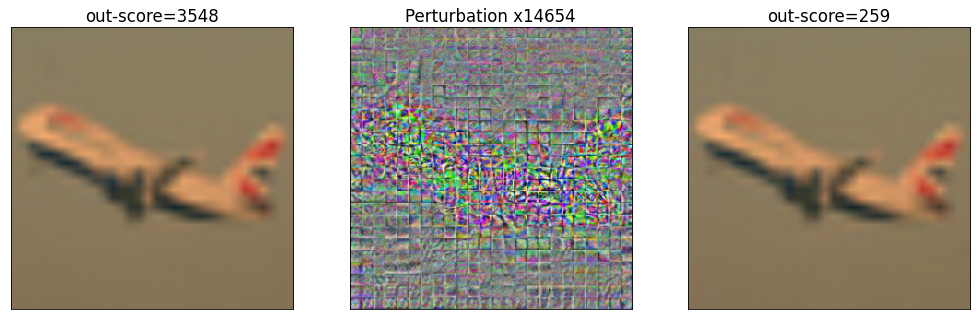

In [59]:
plt.figure(figsize=(3*5.5,5),dpi=75)

plt.subplot(1,3,1)
plt.title("out-score="+str(int(scores_list[0])),fontsize=16)
plt.imshow(np.round((image_start[0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)

im_diff = images_list[-1][0]-image_start[0]

diff_range = np.max(im_diff) - np.min(im_diff)

plt.title("Perturbation x"+str(int(255.0/diff_range)),fontsize=16)

im_diff = im_diff -  np.min(im_diff)
im_diff = im_diff/np.max(im_diff)*255

plt.imshow(np.round(im_diff).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("out-score="+str(int(scores_list[-1])),fontsize=16)
plt.imshow(np.round((images_list[-1][0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.show()

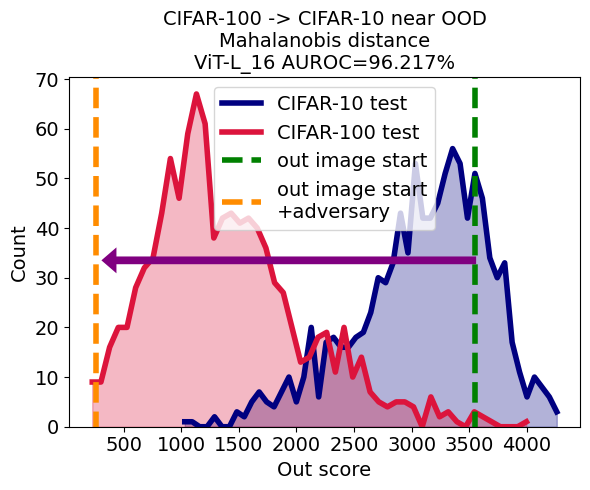

In [60]:
plt.figure(figsize = (6,5),dpi=100)

model_name = "ViT-L_16"

plt.title("CIFAR-100 -> CIFAR-10 near OOD\nMahalanobis distance\n"+model_name+" AUROC="+str(float(maha_auroc*100))[:6]+"%",fontsize=14)

vals,bins = np.histogram(maha_outdist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="CIFAR-10 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

vals,bins = np.histogram(maha_indist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="CIFAR-100 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

plt.xlabel("Out score",fontsize=14)
plt.ylabel("Count",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ylim = plt.gca().get_ylim()

plt.plot([scores_list[0]]*2,[-100,10000],color="green",linewidth=4,
         label="out image start",linestyle="--")

plt.plot([scores_list[-1]]*2,[-100,10000],color="darkorange",linewidth=4,
         label="out image start\n+adversary",linestyle="--")

plt.arrow(scores_list[0],np.mean(ylim),(scores_list[-1]-scores_list[0])*0.95,0,
          linewidth=2,color="purple",width=1,head_width=4,head_length=100,zorder=9)

plt.ylim([0,ylim[-1]])

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

### Many images at once

In [ ]:
images_count = 64 #for a faster run you can generate a small amount

steps = 30
LR = 3e-4

batch_now = next(cifar10_ds_test.as_numpy_iterator())

scores_grid = np.zeros((images_count,steps))*float("NaN")
L2_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")
Linfty_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")

times = []

for i in range(images_count):

  t1_now = time.time()

  image_now = batch_now["image"][i:i+1]
  label_now = batch_now["image"][i:i+1]

  image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
      image_now,
      label_now,
      steps=steps,
      LR=LR,
      gradient_signs_only=True,
      first_gradient_only=False,
      top_k_pixels=None,
      target_score=None,
      use_ratio=False,
      verbose=steps-1,
  )

  scores_grid[i] = np.array(scores_list)
  L2_perturbation_sizes[i] = np.array(L2_perturbation_list)
  Linfty_perturbation_sizes[i] = np.array(Linfty_perturbation_list)

  t2_now = time.time()
  
  times.append(t2_now-t1_now)
  t_rem = np.mean(times)*images_count - np.sum(times)
  print("t_remaining = "+str(int(t_rem))+" seconds")


image=0 step=0 OOD score=4089.2797100994503
image=0 step=29 OOD score=560.5913314688041
t_remaining = 1522 seconds
image=1 step=0 OOD score=4087.1646707616746
image=1 step=29 OOD score=972.5368478137534
t_remaining = 1507 seconds
image=2 step=0 OOD score=2969.5497808165383
image=2 step=29 OOD score=921.4911268348806
t_remaining = 1477 seconds
image=3 step=0 OOD score=3027.955589509802
image=3 step=29 OOD score=268.41961678041844
t_remaining = 1449 seconds
image=4 step=0 OOD score=3422.783419019077


### Score vs perturbation norm

In [ ]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle("Mahalanobis distance, "+model_name+" CIFAR-100 vs CIFAR-10, Fast Gradient Sign Method",fontsize=16)

plt.subplot(1,2,1)

for i in range(images_count):
  if True:
    plt.plot(L2_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(maha_indist_scores)
indist_std = np.std(maha_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])-100,
           np.max(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(maha_outdist_scores)
outdist_std = np.std(maha_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)


plt.subplot(1,2,2)

for i in range(images_count):
  if True:
    plt.plot(Linfty_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(maha_indist_scores)
indist_std = np.std(maha_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])-100,
           np.max(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(maha_outdist_scores)
outdist_std = np.std(maha_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Getting AUROCs

In [ ]:
auroc_list = []
for j in range(steps):

  bools = ~np.isnan(scores_grid[:,j])
  # print(np.sum(bools),len(bools))

  onehots = np.array([1]*len(scores_grid[:,j][bools]) + [0]*len(maha_indist_scores[:]))
  scores = np.concatenate([scores_grid[:,j][bools],maha_indist_scores[:]],axis=0)

  auroc, _ = get_auroc(onehots, scores, make_plot=False)

  auroc_list.append(auroc)

### Interpolating $L_2$ perturbations

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

L2_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = L2_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  L2_to_score_interpolated_fns.append(f_now)

In [ ]:
L2_values_to_scan = np.linspace(
    np.min(L2_perturbation_sizes),
    np.max(L2_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = maha_indist_scores

for i,L2_now in enumerate(L2_values_to_scan):

  bools_morethanmin = L2_now >= np.min(L2_perturbation_sizes,axis=1) 
  bools_lessthanmax = L2_now <= np.max(L2_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(L2_now) for (i,f_now) in enumerate(L2_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_2$ norm

In [ ]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    L2_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_maha_L2_xs = L2_values_to_scan
toreplot_maha_L2_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

### Interpolating $L_\infty$ perturbations

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

Linfty_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = Linfty_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  Linfty_to_score_interpolated_fns.append(f_now)

In [ ]:
Linfty_values_to_scan = np.linspace(
    np.min(Linfty_perturbation_sizes),
    np.max(Linfty_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = maha_indist_scores

for i,Linfty_now in enumerate(Linfty_values_to_scan):

  bools_morethanmin = Linfty_now >= np.min(Linfty_perturbation_sizes,axis=1) 
  bools_lessthanmax = Linfty_now <= np.max(Linfty_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(Linfty_now) for (i,f_now) in enumerate(Linfty_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_\infty$ norm

In [ ]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    Linfty_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_maha_Linfty_xs = Linfty_values_to_scan
toreplot_maha_Linfty_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

## Relative Standard Mahalanobis distance adversaries

### An example image finding

In [ ]:
batch_now = next(cifar10_ds_test.as_numpy_iterator())
i = 34
image_now = batch_now["image"][i:i+1]
label_now = batch_now["image"][i:i+1]

image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
    image_now,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    use_ratio=True,
)

### A nice plot

In [ ]:
plt.figure(figsize=(3*5.5,5),dpi=75)

plt.subplot(1,3,1)
plt.title("out-score="+str(int(scores_list[0])),fontsize=16)
plt.imshow(np.round((image_start[0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)

im_diff = images_list[-1][0]-image_start[0]

diff_range = np.max(im_diff) - np.min(im_diff)

plt.title("Perturbation x"+str(int(255.0/diff_range)),fontsize=16)

im_diff = im_diff -  np.min(im_diff)
im_diff = im_diff/np.max(im_diff)*255

plt.imshow(np.round(im_diff).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("out-score="+str(int(scores_list[-1])),fontsize=16)
plt.imshow(np.round((images_list[-1][0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.show()

In [ ]:
plt.figure(figsize = (6,5),dpi=100)

model_name = "ViT-L_16"

plt.title("CIFAR-100 -> CIFAR-10 near OOD\nRelative Mahalanobis distance\n"+model_name+" AUROC="+str(float(maha_auroc*100))[:6]+"%",fontsize=14)

vals,bins = np.histogram(ratio_outdist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="CIFAR-10 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

vals,bins = np.histogram(ratio_indist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="CIFAR-100 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

plt.xlabel("Out score",fontsize=14)
plt.ylabel("Count",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ylim = plt.gca().get_ylim()

plt.plot([scores_list[0]]*2,[-100,10000],color="green",linewidth=4,
         label="out image start",linestyle="--")

plt.plot([scores_list[-1]]*2,[-100,10000],color="darkorange",linewidth=4,
         label="out image start\n+adversary",linestyle="--")

plt.arrow(scores_list[0],np.mean(ylim),(scores_list[-1]-scores_list[0])*0.88,0,
          linewidth=2,color="purple",width=1,head_width=4,head_length=50,zorder=9)

plt.ylim([0,ylim[-1]])

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

### Many images at once

In [ ]:
images_count = 64 #for a faster run you can generate a small amount

steps = 30
LR = 3e-4

batch_now = next(cifar10_ds_test.as_numpy_iterator())

scores_grid = np.zeros((images_count,steps))*float("NaN")
L2_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")
Linfty_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")

times = []

for i in range(images_count):

  t1_now = time.time()

  image_now = batch_now["image"][i:i+1]
  label_now = batch_now["image"][i:i+1]

  image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary(
      image_now,
      label_now,
      steps=steps,
      LR=LR,
      gradient_signs_only=True,
      first_gradient_only=False,
      top_k_pixels=None,
      target_score=None,
      use_ratio=True,
      verbose=steps-1,
  )

  scores_grid[i] = np.array(scores_list)
  L2_perturbation_sizes[i] = np.array(L2_perturbation_list)
  Linfty_perturbation_sizes[i] = np.array(Linfty_perturbation_list)

  t2_now = time.time()
  
  times.append(t2_now-t1_now)
  t_rem = np.mean(times)*images_count - np.sum(times)
  print("t_remaining = "+str(int(t_rem))+" seconds")


### Score vs perturbation norm

In [ ]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle("Relative Mahalanobis distance, "+model_name+" CIFAR-100 vs CIFAR-10, Fast Gradient Sign Method",fontsize=16)

plt.subplot(1,2,1)

for i in range(images_count):
  if True:
    plt.plot(L2_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(ratio_indist_scores)
indist_std = np.std(ratio_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])-100,
           np.max(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(ratio_outdist_scores)
outdist_std = np.std(ratio_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)


plt.subplot(1,2,2)

for i in range(images_count):
  if True:
    plt.plot(Linfty_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(ratio_indist_scores)
indist_std = np.std(ratio_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])-100,
           np.max(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(ratio_outdist_scores)
outdist_std = np.std(ratio_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Getting AUROCs

In [ ]:
auroc_list = []
for j in range(steps):

  bools = ~np.isnan(scores_grid[:,j])
  # print(np.sum(bools),len(bools))

  onehots = np.array([1]*len(scores_grid[:,j][bools]) + [0]*len(ratio_indist_scores[:]))
  scores = np.concatenate([scores_grid[:,j][bools],ratio_indist_scores[:]],axis=0)

  auroc, _ = get_auroc(onehots, scores, make_plot=False)

  auroc_list.append(auroc)

### Interpolating $L_2$ perturbations

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

L2_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = L2_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  L2_to_score_interpolated_fns.append(f_now)

In [ ]:
L2_values_to_scan = np.linspace(
    np.min(L2_perturbation_sizes),
    np.max(L2_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = ratio_indist_scores

for i,L2_now in enumerate(L2_values_to_scan):

  bools_morethanmin = L2_now >= np.min(L2_perturbation_sizes,axis=1) 
  bools_lessthanmax = L2_now <= np.max(L2_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(L2_now) for (i,f_now) in enumerate(L2_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_2$ norm

In [ ]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    L2_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative",
    )

# to replot later in a combined plot
toreplot_ratio_L2_xs = L2_values_to_scan
toreplot_ratio_L2_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

### Interpolating $L_\infty$ perturbations

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

Linfty_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = Linfty_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  Linfty_to_score_interpolated_fns.append(f_now)

In [ ]:
Linfty_values_to_scan = np.linspace(
    np.min(Linfty_perturbation_sizes),
    np.max(Linfty_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = ratio_indist_scores

for i,Linfty_now in enumerate(Linfty_values_to_scan):

  bools_morethanmin = Linfty_now >= np.min(Linfty_perturbation_sizes,axis=1) 
  bools_lessthanmax = Linfty_now <= np.max(Linfty_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(Linfty_now) for (i,f_now) in enumerate(Linfty_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([1]*len(scores_selected) + [0]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_\infty$ norm

In [ ]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMahalanobis distance",
          fontsize=16)

plt.plot(
    Linfty_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative",
    )

# to replot later in a combined plot
toreplot_ratio_Linfty_xs = Linfty_values_to_scan
toreplot_ratio_Linfty_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

## Maximum of Softmax Probabilities

### Score and gradient tools

In [ ]:
def get_score_with_MSP(
    image, 
    params
    ):

  assert image.shape[0] == 1

  logits = model.apply({'params': params}, image, train=False)
  probs = jax.nn.softmax(logits,axis=-1)

  score = jnp.max(probs,axis=-1)[0]
  return score

In [ ]:
def get_input_grad_with_MSP(image,params):
  return jax.grad(
      lambda image_in: get_score_with_MSP(image_in,params)
  )(image)

In [ ]:
get_score_with_MSP_jit = jax.jit(get_score_with_MSP)
get_input_grad_with_MSP_jit = jax.jit(get_input_grad_with_MSP)

In [ ]:
def find_adversary_against_MSP(
    start_image,
    label_now,
    steps=30,
    LR=3e-4,
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
    verbose=1,
):


  image_now = start_image
  image_start = image_now

  scores_list = []
  images_list = []
  L2_perturbation_list = []
  Linfty_perturbation_list = []

  for it in range(steps):

    score_now = get_score_with_MSP_jit(
        image_now,
        params,
        )
    
    #early stopping
    if (target_score is not None) and (score_now < target_score):
      break
    
    images_list.append(image_now)

    scores_list.append(score_now)
    L2_perturbation_list.append(np.linalg.norm(image_now - image_start))
    Linfty_perturbation_list.append(np.max(np.abs(image_now - image_start)))
    
    if it == 0:
      score_start = score_now
    
    if it % verbose == 0:
      print("image="+str(i)+" step="+str(it)+" OOD score="+str(score_now))
    
    if ((first_gradient_only == False) or (it==0)): 
      image_grad_now = get_input_grad_with_MSP_jit(
          image_now,
          params,
          )
    
    if gradient_signs_only:
      image_grad_now = ((image_grad_now>0.0)*2.0-1.0)


    image_now = image_now - LR*image_grad_now



  return image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list


### An example image finding

In [ ]:
batch_now = next(cifar10_ds_test.as_numpy_iterator())
i = 34
image_now = batch_now["image"][i:i+1]
label_now = batch_now["image"][i:i+1]

image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary_against_MSP(
    image_now,
    label_now,
    steps=30,
    LR=-3e-4, #the score here is reversed
    gradient_signs_only=True,
    first_gradient_only=False,
    top_k_pixels=None,
    target_score=None,
)

### A nice plot

In [ ]:
plt.figure(figsize=(3*5.5,5),dpi=75)

plt.subplot(1,3,1)
plt.title("out-score="+str(int(100*scores_list[0])),fontsize=16)
plt.imshow(np.round((image_start[0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)

im_diff = images_list[-1][0]-image_start[0]

diff_range = np.max(im_diff) - np.min(im_diff)

plt.title("Perturbation x"+str(int(255.0/diff_range)),fontsize=16)

im_diff = im_diff -  np.min(im_diff)
im_diff = im_diff/np.max(im_diff)*255

plt.imshow(np.round(im_diff).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("out-score="+str(int(100*scores_list[-1])),fontsize=16)
plt.imshow(np.round((images_list[-1][0])*255).astype(np.uint8))
plt.xticks([],[])
plt.yticks([],[])

plt.show()

In [ ]:
plt.figure(figsize = (6,5),dpi=100)

model_name = "ViT-L_16"

plt.title("CIFAR-100 -> CIFAR-10 near OOD\nMaximum of Softmax Probs\n"+model_name+" AUROC="+str(float(MSP_auroc*100))[:6]+"%",fontsize=14)

vals,bins = np.histogram(MSP_outdist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="CIFAR-10 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

vals,bins = np.histogram(MSP_indist_scores,bins = 51)
bin_centers = (bins[1:]+bins[:-1])/2.0

plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="CIFAR-100 test")
plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

plt.xlabel("Out score",fontsize=14)
plt.ylabel("Count",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ylim = plt.gca().get_ylim()

plt.plot([scores_list[0]]*2,[-100,10000],color="green",linewidth=4,
         label="out image start",linestyle="--")

plt.plot([scores_list[-1]]*2,[-100,10000],color="darkorange",linewidth=4,
         label="out image start\n+adversary",linestyle="--")

plt.arrow(scores_list[0],np.mean(ylim),(scores_list[-1]-scores_list[0])*0.90,0,
          linewidth=2,color="purple",width=1,head_width=10,head_length=0.05,zorder=9)

plt.ylim([0,ylim[-1]])

plt.legend(fontsize = 14)

plt.tight_layout()
plt.show()

### Many images at once

In [ ]:
images_count = 64 #64 #for a faster run you can generate a small amount

steps = 30
LR = -3e-4 #need to reverse the sign here

batch_now = next(cifar10_ds_test.as_numpy_iterator())

scores_grid = np.zeros((images_count,steps))*float("NaN")
L2_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")
Linfty_perturbation_sizes = np.zeros((images_count,steps))*float("NaN")

times = []

for i in range(images_count):

  t1_now = time.time()

  image_now = batch_now["image"][i:i+1]
  label_now = batch_now["image"][i:i+1]

  image_start, scores_list, images_list, L2_perturbation_list, Linfty_perturbation_list = find_adversary_against_MSP(
      image_now,
      label_now,
      steps=steps,
      LR=LR,
      gradient_signs_only=True,
      first_gradient_only=False,
      top_k_pixels=None,
      target_score=None,
      verbose=steps-1,
  )

  scores_grid[i] = np.array(scores_list)
  L2_perturbation_sizes[i] = np.array(L2_perturbation_list)
  Linfty_perturbation_sizes[i] = np.array(Linfty_perturbation_list)

  t2_now = time.time()
  
  times.append(t2_now-t1_now)
  t_rem = np.mean(times)*images_count - np.sum(times)
  print("t_remaining = "+str(int(t_rem))+" seconds")


### Score vs perturbation norm

In [ ]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle("Max of Softmax Probs, "+model_name+" CIFAR-100 vs CIFAR-10, Fast Gradient Sign Method",fontsize=16)

plt.subplot(1,2,1)

for i in range(images_count):
  if True:
    plt.plot(L2_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(MSP_indist_scores)
indist_std = np.std(MSP_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])-100,
           np.max(L2_perturbation_sizes[~np.isnan(L2_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(MSP_outdist_scores)
outdist_std = np.std(MSP_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)


plt.subplot(1,2,2)

for i in range(images_count):
  if True:
    plt.plot(Linfty_perturbation_sizes[i],scores_grid[i],linewidth=2,color="black",
           marker="",alpha=0.3,zorder=100)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

indist_mean = np.mean(MSP_indist_scores)
indist_std = np.std(MSP_indist_scores)

xlim = plt.gca().get_xlim()

x_range = [
           np.min(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])-100,
           np.max(Linfty_perturbation_sizes[~np.isnan(Linfty_perturbation_sizes)])+100
]

plt.plot(x_range,[indist_mean]*2,linewidth=6,alpha=0.6,color="navy")
plt.fill_between(x_range,
                 [indist_mean-indist_std]*2,
                 [indist_mean+indist_std]*2,
                 alpha=0.3,color="navy",label="In-distribution")


outdist_mean = np.mean(MSP_outdist_scores)
outdist_std = np.std(MSP_outdist_scores)

plt.plot(x_range,[outdist_mean]*2,linewidth=6,alpha=0.6,color="crimson")
plt.fill_between(x_range,
                 [outdist_mean-outdist_std]*2,
                 [outdist_mean+outdist_std]*2,
                 alpha=0.3,color="crimson",label="Out-distribution")

plt.xlim(xlim)

plt.legend(fontsize=16)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("Out-distribution score",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

### Getting AUROCs

In [ ]:
auroc_list = []
for j in range(steps):

  bools = ~np.isnan(scores_grid[:,j])
  # print(np.sum(bools),len(bools))

  onehots = np.array([1]*len(scores_grid[:,j][bools]) + [0]*len(maha_indist_scores[:]))
  scores = np.concatenate([scores_grid[:,j][bools],maha_indist_scores[:]],axis=0)

  auroc, _ = get_auroc(onehots, scores, make_plot=False)

  auroc_list.append(auroc)

### Interpolating $L_2$ perturbations

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

L2_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = L2_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  L2_to_score_interpolated_fns.append(f_now)

In [ ]:
L2_values_to_scan = np.linspace(
    np.min(L2_perturbation_sizes),
    np.max(L2_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = MSP_indist_scores

for i,L2_now in enumerate(L2_values_to_scan):

  bools_morethanmin = L2_now >= np.min(L2_perturbation_sizes,axis=1) 
  bools_lessthanmax = L2_now <= np.max(L2_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(L2_now) for (i,f_now) in enumerate(L2_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([0]*len(scores_selected) + [1]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_2$ norm

In [ ]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMax of Softmax Probs",
          fontsize=16)

plt.plot(
    L2_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_MSP_L2_xs = L2_values_to_scan
toreplot_MSP_L2_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.show()

### Interpolating $L_\infty$ perturbations

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

Linfty_to_score_interpolated_fns = []

for i in range(len(scores_grid)):
  x_now = Linfty_perturbation_sizes[i]
  y_now = scores_grid[i]

  f_now = interpolate.interp1d(x_now, y_now)
  Linfty_to_score_interpolated_fns.append(f_now)

In [ ]:
Linfty_values_to_scan = np.linspace(
    np.min(Linfty_perturbation_sizes),
    np.max(Linfty_perturbation_sizes),
    33
)

collected_aurocs = []

indist_scores = MSP_indist_scores

for i,Linfty_now in enumerate(Linfty_values_to_scan):

  bools_morethanmin = Linfty_now >= np.min(Linfty_perturbation_sizes,axis=1) 
  bools_lessthanmax = Linfty_now <= np.max(Linfty_perturbation_sizes,axis=1) 
  bools = np.logical_and(bools_morethanmin,bools_lessthanmax)

  if np.sum(~bools) == 0: # not missing any images

    scores_selected = [f_now(Linfty_now) for (i,f_now) in enumerate(Linfty_to_score_interpolated_fns) if bools[i]]

    onehots = np.array([0]*len(scores_selected) + [1]*len(indist_scores[:]))
    scores = np.concatenate([scores_selected,indist_scores[:]],axis=0)

    auroc,_ = get_auroc(onehots, scores, make_plot=False)

  else:
    auroc = float("NaN")

  collected_aurocs.append(auroc)

### Plotting AUROC vs $L_\infty$ norm

In [ ]:
plt.figure(figsize=(5.5,5),dpi=75)
plt.title(model_name+
          " for CIFAR-100 vs CIFAR-10\nFast Gradient Sign Method\nMax of Softmax Probs",
          fontsize=16)

plt.plot(
    Linfty_values_to_scan,
    np.array(collected_aurocs),
    linewidth=4,
    color="navy",
    marker="o",
    label="Maha",
    )

# to replot later in a combined plot
toreplot_MSP_Linfty_xs = Linfty_values_to_scan
toreplot_MSP_Linfty_ys = np.array(collected_aurocs)

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=12,loc=3)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)

plt.show()

## Combining the Standard and Relative Mahalanobis distance, and Max of Softmax Probs plots

In [ ]:
plt.figure(figsize=(2*6.5,5),dpi=75)
plt.suptitle(model_name+
          " for CIFAR-100 vs CIFAR-10 Fast Gradient Sign Method",
          fontsize=16)

plt.subplot(1,2,1)

plt.plot(
    toreplot_ratio_L2_xs,
    toreplot_ratio_L2_ys,
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative Maha",
    )

plt.plot(
    toreplot_maha_L2_xs,
    toreplot_maha_L2_ys,
    linewidth=4,
    color="navy",
    marker="o",
    label="Standard Maha",
    )

plt.plot(
    toreplot_MSP_L2_xs,
    toreplot_MSP_L2_ys,
    linewidth=4,
    color="darkorange",
    marker="v",
    label="Max of Softmax Probs",
    )

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=14,loc=1)

plt.xlabel("$L_2$ norm of perturbation, out of $\\approx$665",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)


plt.subplot(1,2,2)

plt.plot(
    toreplot_ratio_Linfty_xs,
    toreplot_ratio_Linfty_ys,
    linewidth=4,
    color="crimson",
    marker="s",
    label="Relative Maha",
    )

plt.plot(
    toreplot_maha_Linfty_xs,
    toreplot_maha_Linfty_ys,
    linewidth=4,
    color="navy",
    marker="o",
    label="Standard Maha",
    )

plt.plot(
    toreplot_MSP_Linfty_xs,
    toreplot_MSP_Linfty_ys,
    linewidth=4,
    color="darkorange",
    marker="v",
    label="Max of Softmax Probs",
    )

xlim = plt.gca().get_xlim()

plt.plot([-10,1000],[0.5]*2,linewidth=5,linestyle="--",alpha=0.3,color="black",label="Parity")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)

plt.xlim(xlim)

plt.legend(fontsize=14,loc=1)

plt.xlabel("$L_\infty$ norm of perturbation, out of 1",fontsize=16)
plt.ylabel("CIFAR-100 vs (CIFAR-10+adv)\nAUROC",fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()